# Digital Signal Processing and Simulation
## 03: Band Ratios

This tutorial was adapted for SPR 2023 by Michael Preston. The original can be found [here](https://fooof-tools.github.io/fooof/auto_motivations/measurements/plot_BandRatios.html). 

Introduction
------------

Band ratios measures are a relatively common measure, proposed to measure oscillatory,
or periodic, activity.

They are typically calculated as:

\begin{align}BR = \frac{avg(low band power)}{avg(high band power)}\end{align}

In this notebook we will explore this measure in the context of conceptualizing
neural power spectra as a combination of aperiodic and periodic activity.

For more investigation into band ratios, their methodological issues, applications to real
data, and a comparison to parameterizing power spectra, see our full project
[here](https://github.com/voytekresearch/BandRatios).





### Set-up

In [1]:
# Install necessary packages (for Colab)
!pip install fooof

#### Imports

In [2]:
# general 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import simulation, utility, and plotting tools
from fooof.bands import Bands
from fooof.utils import trim_spectrum
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra_shading, plot_spectrum

C:\Users\micha\AppData\Local\Temp\ipykernel_7180\3209597662.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.bands import Bands


#### Settings

In [3]:
# General Settings

# signal params
n_seconds = 100 # signal duration
fs = 1000 # sampling frequency

# Define band definitions
bands = Bands({'theta' : [4, 8], 'beta' : [20, 30]})

# Define helper variables for indexing peak data
icf, ipw, ibw = 0, 1, 2

In [4]:
# plotting params

# fontsize
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10

# color
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['axes.facecolor'] = 'w'
shade_color = '#0365C0'


### Simulating power 

For this example, we will use simulated data. Let's start by simulating a
a baseline power spectrum.

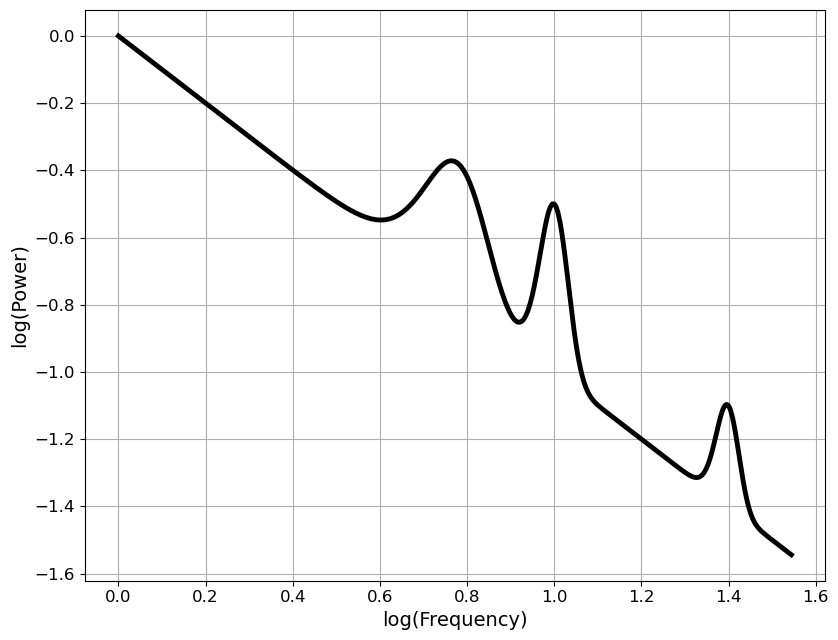

In [5]:
# Simulation Settings
nlv = 0 # noise level - no noise
f_res = 0.1 # frequency resolution
f_range = [1, 35] # frequency range (Hz)

# Define default aperiodic values
ap = [0, 1] # offset, exponent

# Define default periodic values for band specific peaks 
# parameters: [center frequency, power, bandwidth]
theta = [6, 0.4, 1]
alpha = [10, 0.5, 0.75]
beta  = [25, 0.3, 1.5]

# Set random seed, for consistency generating simulated data
set_random_seed(21)

# Simulate a power spectrum
freqs, powers = gen_power_spectrum(f_range, ap, [theta, alpha, beta], nlv, f_res)

# Plot the power spectrum
plot_spectrum(freqs, powers, log_powers=True, log_freqs=True,
                     color='black', linewidth=3.5)


### Calculating Band Ratios

Band ratio measures are a ratio of power between defined frequency bands.

We can now define a function we can use to calculate band ratio measures, and
apply it to our baseline power spectrum.

For this example, we will be using the theta / beta ratio, which is the
most commonly applied band ratio measure.

Note that it doesn't matter exactly which ratio measure or which frequency band
definitions we use, as the general properties demonstrated here generalize
to different bands and ranges.

In [6]:
def calc_band_ratio(freqs, powers, low_band, high_band):
    """Helper function to calculate band ratio measures."""

    # Extract frequencies within each specified band
    _, low_band = trim_spectrum(freqs, powers, low_band)
    _, high_band = trim_spectrum(freqs, powers, high_band)

    # Calculate average power within each band, and then the ratio between them
    ratio = np.mean(low_band) / np.mean(high_band)

    return ratio

Calculate theta / beta ratio is :	 5.74


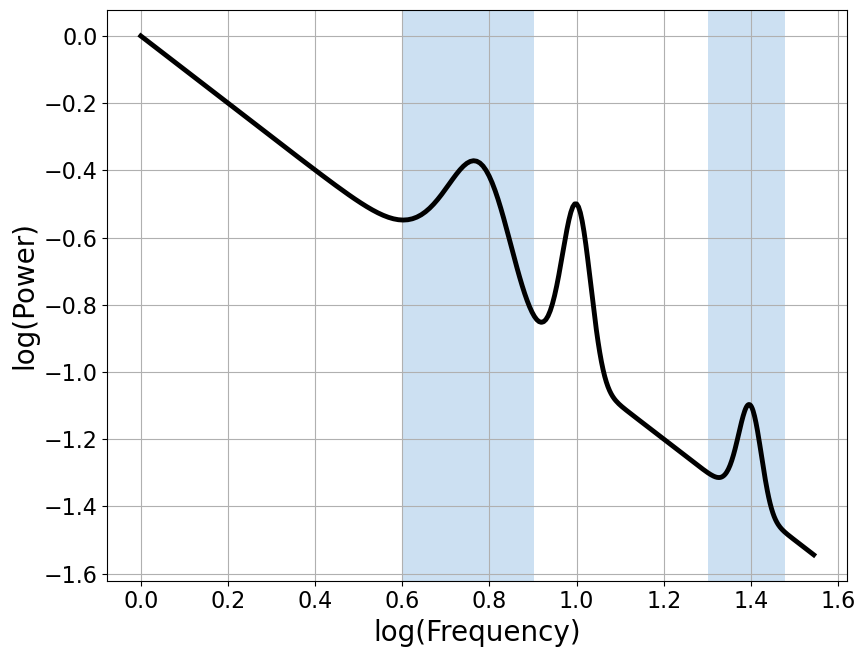

In [7]:
# Calculate a band ratio measure

# Plot the power spectrum, shading the frequency bands used for the ratio
plot_spectra_shading(freqs, powers, [bands.theta, bands.beta],
                     color='black', shade_colors=shade_color,
                     log_powers=True, log_freqs=True, linewidth=3.5)

# Calculate a band ratio measure
tbr = calc_band_ratio(freqs, powers, bands.theta, bands.beta)
print('Calculate theta / beta ratio is :\t {:1.2f}'.format(tbr))


### Periodic Impacts on Band Ratio Measures

Typical investigations involving band ratios compare differences in band ratio measures
within and between subjects. The typical interpretation of band ratio measures is that
they relate to the relative power between two bands.

Next, lets simulate data that varies across different periodic parameters of the data, and
see how this changes our measured theta / beta ratio, as compared to our baseline
power spectrum. Here we systematically vary either the center frequency, power, or bandwidth
of the theta, alpha, or beta peak. 




In [8]:
# Define a helper function for updating parameters
from copy import deepcopy
def upd(data, index, value):
    """Return a updated copy of an array."""
    out = deepcopy(data)
    out[index] = value
    return out

In [9]:
# Simulate and collect power spectra with changes in each periodic parameter
spectra = {
    'Theta Frequency' : None,
    'Theta Power' : gen_power_spectrum(\
        f_range, ap, [upd(theta, ipw, 0.5041), alpha, beta], nlv, f_res)[1],
    'Theta Bandwidth' : gen_power_spectrum(\
        f_range, ap, [upd(theta, ibw, 1.61), alpha, beta], nlv, f_res)[1],
    'Alpha Frequency' : gen_power_spectrum(\
        f_range, ap, [theta, upd(alpha, icf, 8.212), beta], nlv, f_res)[1],
    'Alpha Power' : None,
    'Alpha Bandwidth' : gen_power_spectrum(\
        f_range, ap, [theta, upd(alpha, ibw, 1.8845), beta], nlv, f_res)[1],
    'Beta Frequency' : gen_power_spectrum(\
        f_range, ap, [theta, alpha, upd(beta, icf, 19.388)], nlv, f_res)[1],
    'Beta Power' : gen_power_spectrum(\
        f_range, ap, [theta, alpha, upd(beta, ipw, 0.1403)], nlv, f_res)[1],
    'Beta Bandwidth' : gen_power_spectrum(\
        f_range, ap, [theta, alpha, upd(beta, ibw, 0.609)], nlv, f_res)[1],
}

In [26]:
# Calculate change in theta / beta ratio for each parameter change
for label, spectrum in spectra.items():
    if spectrum is not None:
        change = tbr - calc_band_ratio(freqs, spectrum, bands.theta, bands.beta)
        print(f'TBR difference from change in {label.lower():15}:\t {change:1.3f}')

TBR difference from change in theta power    :	 -1.000
TBR difference from change in theta bandwidth:	 -1.000
TBR difference from change in alpha frequency:	 -1.000
TBR difference from change in alpha bandwidth:	 -1.000
TBR difference from change in beta frequency :	 -1.000
TBR difference from change in beta power     :	 -1.000
TBR difference from change in beta bandwidth :	 -1.000


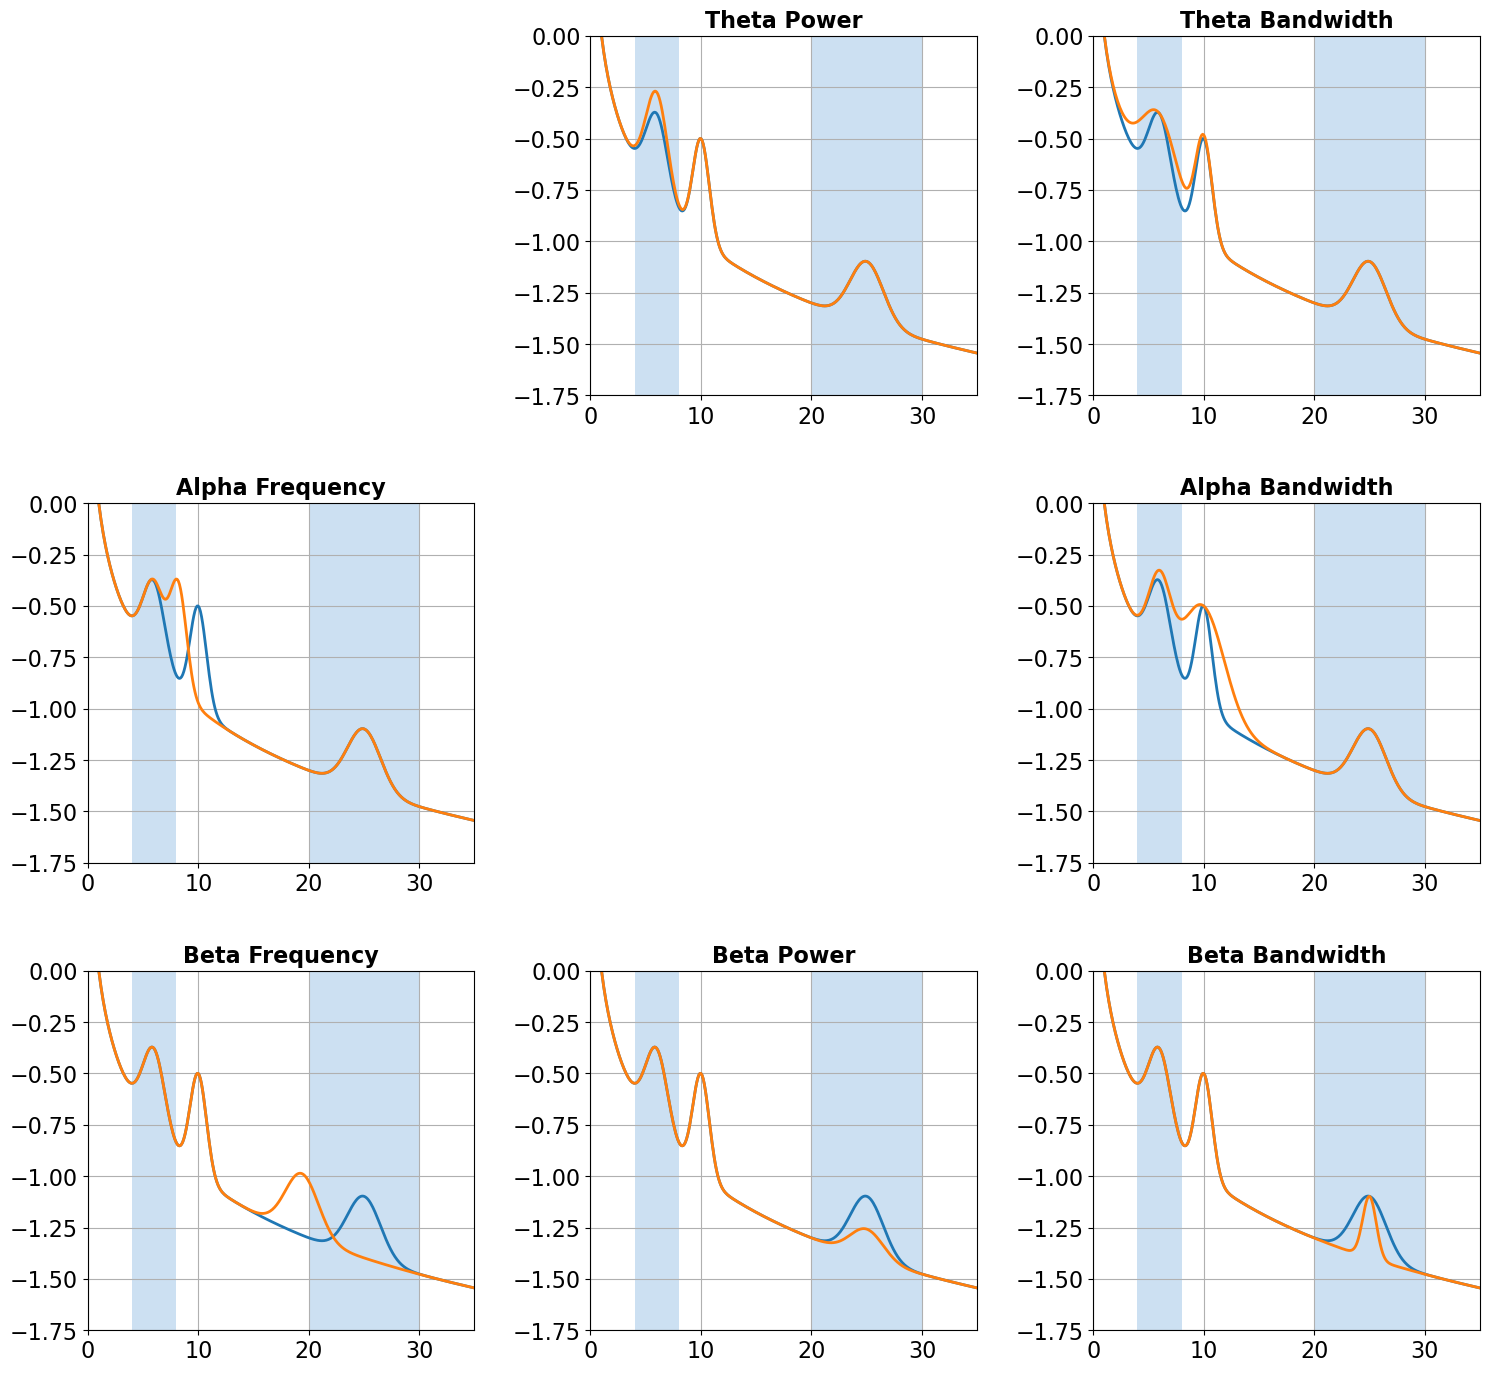

In [11]:
# Create figure of periodic changes
title_settings = {'fontsize': 16, 'fontweight': 'bold'}
fig, axes = plt.subplots(3, 3, figsize=(15, 14))

for ax, (label, spectrum) in zip(axes.flatten(), spectra.items()):

    if spectrum is None: continue

    plot_spectra_shading(freqs, [powers, spectrum],
                         [bands.theta, bands.beta], shade_colors=shade_color,
                         log_freqs=False, log_powers=True, ax=ax)

    ax.set_title(label, **title_settings)
    ax.set_xlim([0, 35]); ax.set_ylim([-1.75, 0])
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

# Turn off empty axes & space out axes
fig.subplots_adjust(hspace=.3, wspace=.3)
_ = [ax.axis('off') for ax in [axes[0, 0], axes[1, 1]]]

In the simulations above, we systematically manipulated each parameter of each of the
three different band peaks present in our data. For 7 of the 9 possible changes, we can
do so in a way that creates an identical change in the measured band ratio measure.

Band ratio measures are therefore not specific to band power differences, but rather
can reflect multiple different changes across multiple different periodic parameters.

### Aperiodic Impacts on Band Ratio Measures

Next, we can also examine if changes in aperiodic properties of the data can also
impact band ratio measures. We will explore changes in the aperiodic exponent, with
and without overlying peaks.

To do so, we will use the same approach to simulating, comparing, and plotting
data as above (though note that the code to do so has been condensed in the
next section).

In [27]:
# Simulate and collect power spectra with changes in aperiodic parameters
exp_spectra = {
    'Exponent w Peaks' : \
        [powers,
         gen_power_spectrum(f_range, [0.13, 1.1099],
                            [theta, alpha, beta], nlv, f_res)[1]],
    'Exponent w/out Peaks' : \
        [gen_power_spectrum(f_range, ap, [], nlv, f_res)[1],
         gen_power_spectrum(f_range, [0.13, 1.1417], [], nlv, f_res)[1]]}

TBR difference from change in exponent w peaks present    :	 -1.000
TBR difference from change in exponent w/out peaks present:	 -1.000


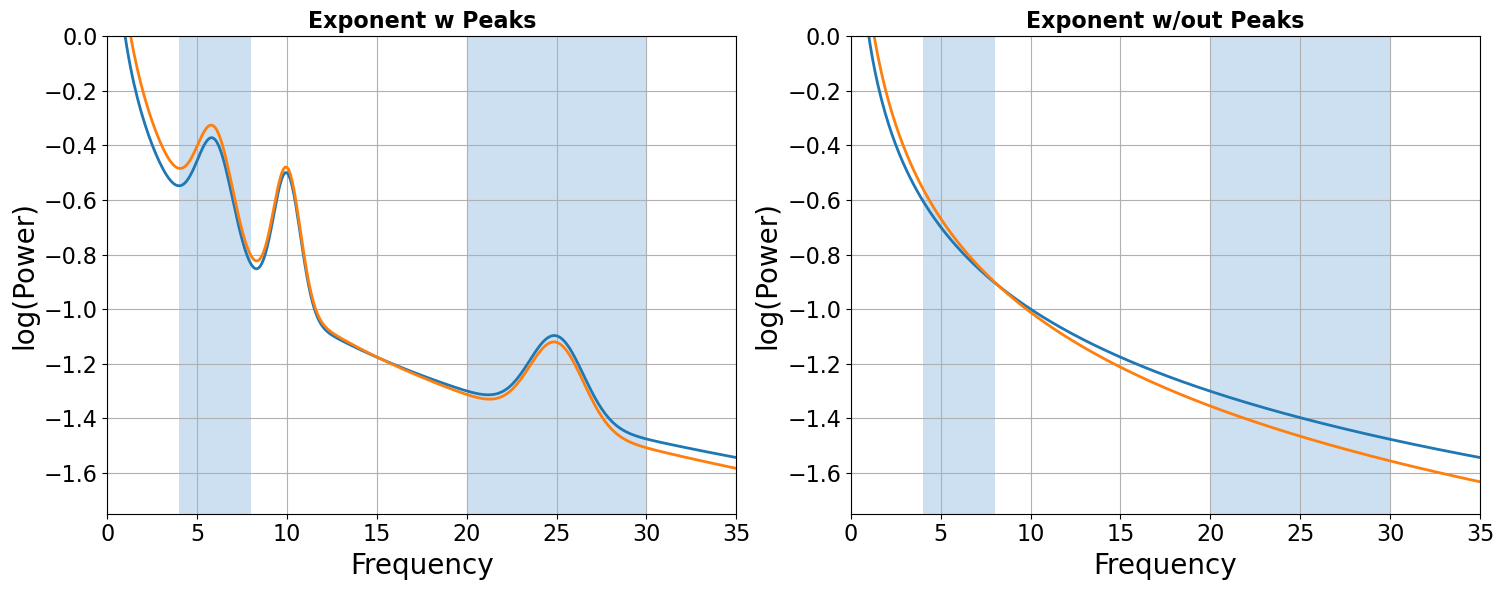

In [42]:
# Calculate & plot changes in theta / beta ratios
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=.3)
for ax, (label, (comparison, spectrum)) in zip(axes, exp_spectra.items()):
    change = calc_band_ratio(freqs, comparison, bands.theta, bands.beta) - \
        calc_band_ratio(freqs, spectrum, bands.theta, bands.beta)
    print(f'TBR difference from change in {f"{label.lower()} present":28}:\t {change:1.3f}')
    plot_spectra_shading(freqs, [comparison, spectrum],
                         [bands.theta, bands.beta],
                         shade_colors=shade_color,
                         log_freqs=False, log_powers=True, ax=ax)
    ax.set_title(label, **title_settings)
    ax.set_xlim([0, 35]); ax.set_ylim([-1.75, 0])

In these simulations, we again see that we can obtain the same measured difference in
band ratio measures from differences in the aperiodic properties of the data. This is
true even if there are no periodic peaks present at all.

This shows that band ratio measures are not even specific to periodic activity,
and can be driven entirely by changes in aperiodic activity.




## Conclusion

Band ratio measures are supposed to reflect the relative power of rhythmic neural activity.

However, here we can see that band ratio measures are actually under-determined in that many different changes of both periodic and aperiodic parameters can affect band ratio measurements - including aperiodic changes when there is no periodic activity present.

For this reason, we conclude that band-ratio measures, by themselves, are an insufficient measure of neural activity. We propose that approaches such as parameterizing power spectra are more specific for adjudicating what is changing in neural data. 

Section 01 of this workshop, Spectral Parameterization, will introduce the method for parameterizing power spectra described in:

Donoghue T, Haller M, Peterson EJ, Varma P, Sebastian P, Gao R, Noto T, Lara AH, Wallis JD, Knight RT, Shestyuk A, & Voytek B (2020).  Parameterizing neural power spectra into periodic and aperiodic components. *Nature Neuroscience, 23*, 1655-1665. [DOI: 10.1038/s41593-020-00744-x](https://doi.org/10.1038/s41593-020-00744-x) 



